<a href="https://colab.research.google.com/github/WanPgui/Mold_Prediction/blob/main/mold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow numpy matplotlib

In [2]:
pip install scikit-learn opencv-python

In [3]:
# Imports
import os, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [4]:
# Set dataset directory (customize)
DATA_DIR = '/content/drive/MyDrive/mold_images'

In [5]:
import os
os.listdir(DATA_DIR)

['README.roboflow.txt', 'data.yaml', 'train', 'test', 'valid']

In [6]:
# Parameters
IMG_SIZE = (224,224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20
MODEL_SAVE_PATH = "/content/mold_model_best.h5"

In [7]:
# Create tf datasets
train_dir = os.path.join(DATA_DIR,'train')
val_dir = os.path.join(DATA_DIR,'valid')
test_dir = os.path.join(DATA_DIR,'test')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary', seed=123)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary', seed=123)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary', shuffle=False)


Found 5930 files belonging to 2 classes.
Found 1245 files belonging to 2 classes.
Found 694 files belonging to 2 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import os

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = '/content/drive/MyDrive/mold_images'

# Define classes based on folder names
class_names = ['images', 'labels']  # class 0 = images, class 1 = labels

def load_split(split):
    split_dir = os.path.join(DATA_DIR, split)
    ds = tf.keras.utils.image_dataset_from_directory(
        split_dir,
        labels='inferred',
        label_mode='binary',
        class_names=class_names,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=123
    )
    return ds

# Load each dataset split
train_ds = load_split('train')
val_ds = load_split('valid')
test_ds = load_split('test')

# ------------------------------
# Preprocessing and augmentation
# ------------------------------
def prepare(ds, augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.08),
            layers.RandomZoom(0.08),
            layers.RandomContrast(0.08),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# --- Sanity check ---
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Unique labels in this batch:", np.unique(labels.numpy()))


Found 5930 files belonging to 2 classes.
Found 1245 files belonging to 2 classes.
Found 694 files belonging to 2 classes.
Batch shape: (32, 224, 224, 3)
Unique labels in this batch: [0. 1.]


In [9]:
labels = np.concatenate([y.numpy() for _, y in train_ds])
np.unique(labels, return_counts=True)


(array([0., 1.], dtype=float32), array([5135,  795]))

In [9]:
import os

# Define class names based on the directory structure
class_names = ["labels", "images"] # 'labels' is class 0 and 'images' is class 1

for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(DATA_DIR, split)
    print(f"\n{split} class counts:")
    class_counts = {}
    for cls_name in class_names:
        cls_path = os.path.join(split_dir, cls_name)
        if os.path.isdir(cls_path):
            class_counts[cls_name] = len(os.listdir(cls_path))
        else:
            class_counts[cls_name] = 0 # Or handle the case where the directory doesn't exist
    print(class_counts)


train class counts:
{'labels': 796, 'images': 5135}

valid class counts:
{'labels': 467, 'images': 778}

test class counts:
{'labels': 313, 'images': 381}


In [10]:
# ------------------------------
# EfficientNetB0 Transfer Learning for Mold Detection
# ------------------------------

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import random, os

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ------------------------------
# Parameters
# ------------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/content/drive/MyDrive/mold_images'
MODEL_SAVE_PATH = "/content/best_mold_model.keras"
FINAL_MODEL_PATH = "/content/mold_model_final.keras"
AUTOTUNE = tf.data.AUTOTUNE

# ------------------------------
# Load datasets
# ------------------------------
# Assuming 'labels' is class 0 and 'images' is class 1 based on your folder setup
class_names = ["labels", "images"]

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred",
    label_mode="binary",
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "valid"),
    labels="inferred",
    label_mode="binary",
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="binary",
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ------------------------------
# Preprocessing and augmentation
# ------------------------------
def prepare(ds, augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.08),
            layers.RandomZoom(0.08),
            layers.RandomContrast(0.08),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# ------------------------------
# Compute class weights (flatten labels!)
# ------------------------------
y_train_all = np.concatenate([y.numpy().flatten() for x, y in train_ds])
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_all), y=y_train_all)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# ------------------------------
# Build EfficientNetB0 Model
# ------------------------------
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base.trainable = False  # Freeze base initially

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

# ------------------------------
# Callbacks
# ------------------------------
callbacks = [
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# ------------------------------
# Initial Training (Frozen Base)
# ------------------------------
print("\n=== Initial Training (Frozen Base) ===")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ------------------------------
# Fine-tuning Top Layers
# ------------------------------
print("\n=== Fine-Tuning Top Layers ===")
base.trainable = True
fine_tune_at = int(len(base.layers) * 0.7)
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ------------------------------
# Evaluate on Test Set
# ------------------------------
print("\n=== Evaluating on Test Set ===")
model.load_weights(MODEL_SAVE_PATH)

y_true, y_prob = [], []
for images, labels in test_ds:
    probs = model.predict(images).ravel()
    y_prob.extend(probs.tolist())
    y_true.extend(labels.numpy().tolist())

y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

# Compute metrics safely
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1])

try:
    auc = roc_auc_score(y_true, y_prob)
except ValueError:
    auc = float('nan')

print("\nConfusion Matrix:\n", conf_matrix)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

# ------------------------------
# Save Final Model
# ------------------------------
model.save(FINAL_MODEL_PATH)
print(f"\nFinal model saved to: {FINAL_MODEL_PATH}")


Found 5930 files belonging to 2 classes.
Found 1245 files belonging to 2 classes.
Found 694 files belonging to 2 classes.
Class weights: {0: np.float64(3.729559748427673), 1: np.float64(0.5774099318403116)}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 4,049,827 (15.45 MB)


=== Initial Training (Frozen Base) ===
Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6208 - auc: 0.7905 - loss: 0.6261 - precision: 0.9482 - recall: 0.5930
Epoch 1: val_loss improved from inf to 0.27665, saving model to /content/best_mold_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 755s 4s/step - accuracy: 0.6211 - auc: 0.7911 - loss: 0.6254 - precision: 0.9483 - recall: 0.5933 - val_accuracy: 0.9277 - val_auc: 0.9915 - val_loss: 0.2767 - val_precision: 0.9943 - val_recall: 0.8895 - learning_rate: 1.0000e-04
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7702 - auc: 0.9738 - loss: 0.3171 - precision: 0.9958 - recall: 0.7364
Epoch 2: val_loss improved from 0.27665 to 0.19476, saving model to /content/best_mold_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 635s 3s/step - accuracy: 0.7702 - auc: 0.9738 - loss: 0.3171 - precision: 0.9958 - recall: 0.7365 - val_accuracy: 0.9430 - val_auc: 0.9949 - val_loss: 0.1948 - val_precision: 0.9986 - val_recall: 0.9100 - 

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 144 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Confusion Matrix:
 [[311   2]
 [  3 378]]

Precision: 0.9947
Recall: 0.9921
F1-score: 0.9934
ROC AUC: 0.9983

Classification Report:
              precision    recall  f1-score   support

         0.0     0.

In [11]:
from google.colab import files

files.download("/content/mold_model_final.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

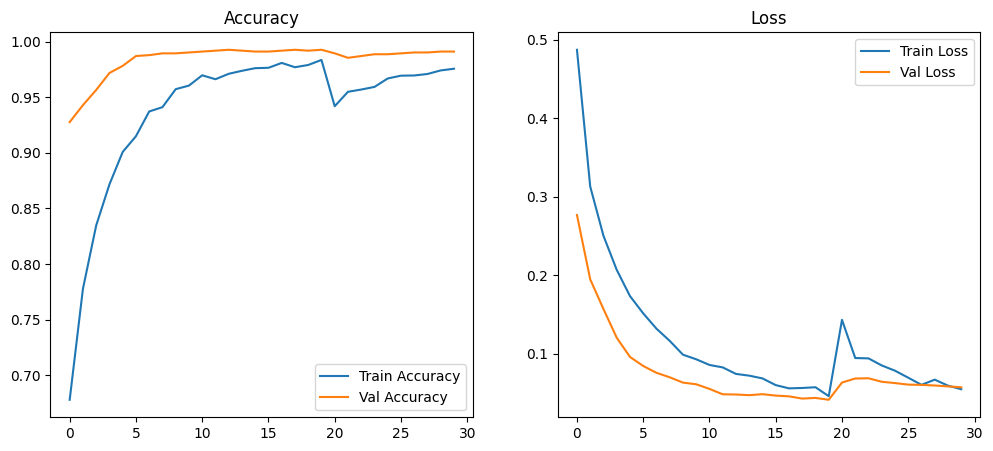

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()


In [13]:
import os

for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    if os.path.isdir(cls_path):
        print(f"{cls}: {len(os.listdir(cls_path))} images")

images: 381 images
labels: 313 images


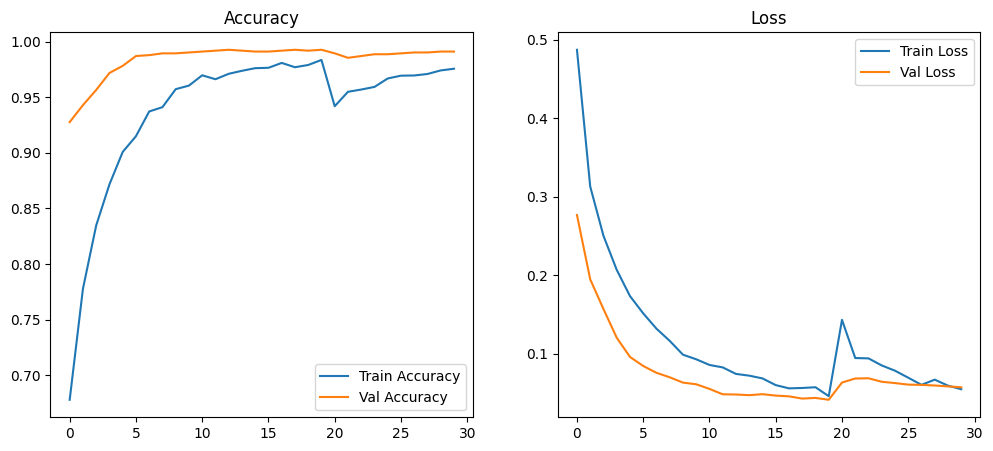

In [14]:
# --------------------------
# Grad-CAM helper functions
# --------------------------
import cv2, numpy as np, tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def save_and_display_gradcam(orig_path, heatmap, cam_path='cam.jpg', alpha=0.4):
    img = cv2.imread(orig_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    cv2.imwrite(cam_path, cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_RGB2BGR))
    print("Saved Grad-CAM to:", cam_path)

import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()



In [15]:
# --------------------------
# Grad-CAM helper functions
# --------------------------
import cv2, numpy as np, tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def save_and_display_gradcam(orig_path, heatmap, cam_path='cam.jpg', alpha=0.4):
    img = cv2.imread(orig_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    cv2.imwrite(cam_path, cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_RGB2BGR))
    print("Saved Grad-CAM to:", cam_path)

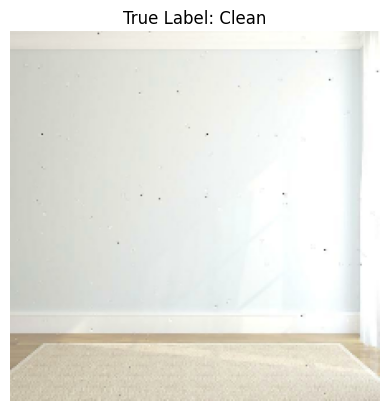

Using last conv layer: top_conv


ValueError: No such layer: top_conv. Existing layers are: ['input_layer_3', 'efficientnetb0', 'global_average_pooling2d', 'dropout', 'dense', 'batch_normalization', 'dropout_1', 'dense_1'].

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Grad-CAM helper ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check last_conv_layer_name.")
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8  # avoid divide-by-zero
    return heatmap

# --- Select an image from test_ds ---
for img_batch, label_batch in test_ds.take(1):
    img_array = img_batch[0].numpy()
    true_label = label_batch[0].numpy()

plt.imshow(img_array.astype("uint8"))
plt.title(f"True Label: {'Mold' if true_label==1 else 'Clean'}")
plt.axis("off")
plt.show()

# --- Prepare input for Grad-CAM ---
img_tensor = np.expand_dims(preprocess_input(img_array), axis=0)


# Find the last convolutional layer in the base model (efficientnetb0)
last_conv_layer_name = None
# Access the efficientnetb0 layer within your model (assuming it's the second layer)
efficientnet_base = model.layers[1]
for layer in reversed(efficientnet_base.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("Could not find a convolutional layer in the EfficientNetB0 base model.")

print(f"Using last conv layer: {last_conv_layer_name}")

# --- Generate heatmap ---
# Ensure the model is loaded with the correct weights if needed
# model.load_weights(MODEL_SAVE_PATH) # Uncomment if you need to load best weights

heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)

# --- Overlay heatmap ---
def superimpose(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Ensure img is in BGR format for cv2.addWeighted
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img_bgr, 1 - alpha, 0)
    return superimposed_img

superimposed_img = superimpose(img_array.astype("uint8"), heatmap)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_array.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
# Convert back to RGB for matplotlib display
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM: Mold Focus Regions")
plt.axis("off")
plt.show()

In [18]:
cv2.imwrite("gradcam_mold_sample.jpg", cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))


NameError: name 'superimposed_img' is not defined